### Using RNNs to predict time series

We will be using Tensorflow's layers for processing sequence data such as Recurrent layers or LSTMs to see how these two approaches compare.


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from absl import logging
logging.set_verbosity(logging.ERROR)

## Generating the data

The next cell includes a bunch of helper functions to generate and plot the time series:

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """An arbitrary pattern"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

We will be generating time series data 




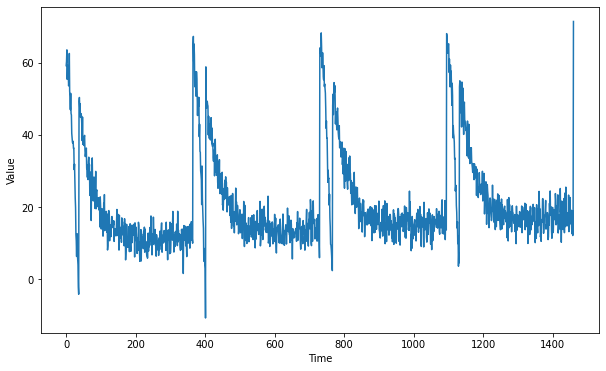

In [3]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series


@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000
    

plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Processing the data



In [4]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [5]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# Apply the transformation to the training set
dataset = windowed_dataset(series_train)

## Defining the model architecture


In [8]:
def create_uncompiled_model():
    
    model = tf.keras.models.Sequential([ 
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
    ]) 
    

    return model

In [9]:

uncompiled_model = create_uncompiled_model()

try:
    uncompiled_model.predict(dataset)
except:
    print("Your current architecture is incompatible with the windowed dataset, try adjusting it.")
else:
    print("Your current architecture is compatible with the windowed dataset! :)")

Your current architecture is compatible with the windowed dataset! :)


## Adjusting the learning rate 


In [12]:
def adjust_learning_rate():
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
    
    
    optimizer = 'adam'
    
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 
    
    
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [13]:
lr_history = adjust_learning_rate()

Epoch 1/100
34/34 [==============================] - 10s 81ms/step - loss: 31.8061 - mae: 32.3061 - lr: 1.0000e-06
Epoch 2/100
34/34 [==============================] - 2s 70ms/step - loss: 30.9572 - mae: 31.4572 - lr: 1.1220e-06
Epoch 3/100
34/34 [==============================] - 2s 64ms/step - loss: 30.0053 - mae: 30.5050 - lr: 1.2589e-06
Epoch 4/100
34/34 [==============================] - 2s 60ms/step - loss: 28.9383 - mae: 29.4383 - lr: 1.4125e-06
Epoch 5/100
34/34 [==============================] - 2s 64ms/step - loss: 27.7419 - mae: 28.2419 - lr: 1.5849e-06
Epoch 6/100
34/34 [==============================] - 2s 63ms/step - loss: 26.3973 - mae: 26.8970 - lr: 1.7783e-06
Epoch 7/100
34/34 [==============================] - 2s 62ms/step - loss: 24.8931 - mae: 25.3931 - lr: 1.9953e-06
Epoch 8/100
34/34 [==============================] - 2s 64ms/step - loss: 23.2018 - mae: 23.7015 - lr: 2.2387e-06
Epoch 9/100
34/34 [==============================] - 2s 64ms/step - loss: 21.3087 - mae

(1e-06, 1.0, 0.0, 30.0)

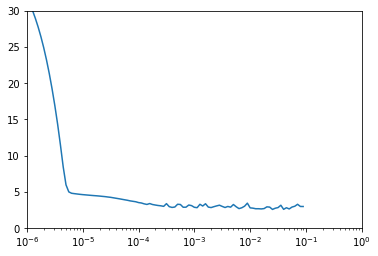

In [14]:
# Plot the loss for every LR
plt.semilogx(lr_history.history["lr"], lr_history.history["loss"])
plt.axis([1e-6, 1, 0, 30])

## Compiling the model

It is time to do the actual training that will be used to forecast the time series

In [18]:
def create_model():

    tf.random.set_seed(51)
    
    model = create_uncompiled_model()

#     tf.keras.backend.clear_session()

    # Build the model
    model = tf.keras.models.Sequential([
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                          input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
      tf.keras.layers.Dense(1),
      tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])

    # Set the learning rate
    learning_rate = 4e-4

    # Set the optimizer
    optimizer = 'adam'
    
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 

    return model

In [19]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(dataset, epochs=50)

Epoch 1/50
34/34 [==============================] - 9s 73ms/step - loss: 9.1933 - mae: 9.6759
Epoch 2/50
34/34 [==============================] - 2s 61ms/step - loss: 4.0116 - mae: 4.4824
Epoch 3/50
34/34 [==============================] - 2s 58ms/step - loss: 3.6168 - mae: 4.0843
Epoch 4/50
34/34 [==============================] - 2s 55ms/step - loss: 3.2723 - mae: 3.7371
Epoch 5/50
34/34 [==============================] - 2s 55ms/step - loss: 2.9990 - mae: 3.4568
Epoch 6/50
34/34 [==============================] - 2s 58ms/step - loss: 2.8765 - mae: 3.3389
Epoch 7/50
34/34 [==============================] - 2s 56ms/step - loss: 3.0142 - mae: 3.4808
Epoch 8/50
34/34 [==============================] - 2s 58ms/step - loss: 3.0092 - mae: 3.4776
Epoch 9/50
34/34 [==============================] - 2s 59ms/step - loss: 3.2272 - mae: 3.6972
Epoch 10/50
34/34 [==============================] - 2s 59ms/step - loss: 3.1776 - mae: 3.6456
Epoch 11/50
34/34 [==============================] - 2s 58m

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast.

In [20]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

At this point only the model that will perform the forecast is ready but you still need to compute the actual forecast. 

## Faster model forecasts


In [21]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

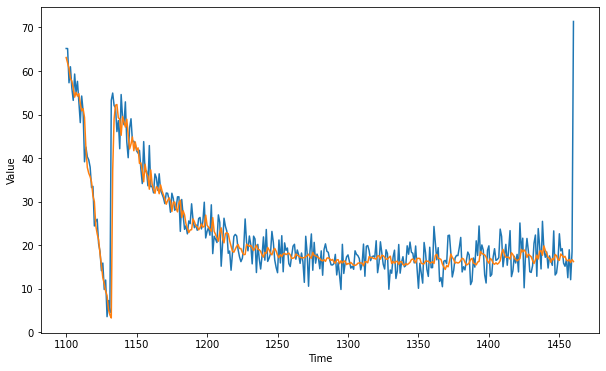

In [22]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot it
plt.figure(figsize=(10, 6))

plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [23]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 27.92, mae: 3.03 for forecast


In [24]:
# Save your model in the SavedModel format
model.save('saved_model/my_model')

# Compress the directory using tar
! tar -czvf saved_model.tar.gz saved_model/

INFO:tensorflow:Assets written to: saved_model/my_model/assets


INFO:tensorflow:Assets written to: saved_model/my_model/assets


saved_model/
saved_model/my_model/
saved_model/my_model/keras_metadata.pb
saved_model/my_model/variables/
saved_model/my_model/variables/variables.data-00000-of-00001
saved_model/my_model/variables/variables.index
saved_model/my_model/saved_model.pb
saved_model/my_model/assets/
